# Solving a Simple RBC Model Using [Rehndal's](https://www.ihs.ac.at/publications/eco/es-330.pdf) Algorithm


## Simple RBC Model

Imagine the standard RBC model which can be summarized by these equations

\begin{align}\begin{aligned}C_t^{-\gamma} &= \beta \mathbb E_t \left[ R_{t+1} C_{t+1}^{-\gamma} \right]\\R_t &= \alpha Z_t \left( K_{t-1} / \bar L \right)^{\alpha-1} + 1 - \delta\\K_t &= (1-\delta)K_{t-1}+Y_t - C_t\\Y_t &= Z_t K_{t-1}^\alpha \bar L^{1-\alpha}\\\log Z_t &= \rho \log Z_{t-1} + \varepsilon_{t}.\end{aligned}\end{align}

We need to solve for $X_t := (C_t, R_t, K_t, Y_t, Z_t)$. We set $L = 1$ for simplicity.

We can linearize these equations and represent them as:

$$
A \mathbb E_t X_{t+1} + B X_t + C X_{t-1} + \mathcal E \epsilon_t = 0,
$$

The steady state is given by:

\begin{align}\begin{aligned}Z &= 1\\R &= 1/ \beta\\K &= \left( \frac{R-1+\delta}{\alpha} \right)^{1/(\alpha - 1)}\\Y &= K^\alpha\\C &= Y - \delta K.\end{aligned}\end{align}

## Rehndal's Algorithm

The algorithm uses a guess and verify approach. 

Imagine the solution takes the form $X_t = P X_{t-1} + Q \epsilon_t$ where $P$ and $Q$ are coefficient matrices to be found. Replace this in our linearized model and we can get:

\begin{align}\begin{aligned}A \mathbb E_t \left[ P X_t + Q \epsilon_{t+1} \right] + B X_t + C X_{t-1} + \mathcal E \epsilon_t &= 0\\A \mathbb E_t \left[ P \left( P X_{t-1} + Q \epsilon_t \right) + Q \epsilon_{t+1} \right] + B \left( P X_{t-1} + Q \epsilon_t \right) + C X_{t-1} + \mathcal E \epsilon_t &= 0\\\left[A P^2 + B P  + C  \right] X_{t-1} + \left[ A P Q  + B Q   + \mathcal E \right] \epsilon_t   &= 0.\end{aligned}\end{align}

The algorithm goes like this:

1. Start with a guess for $P$. Let it be $P^0$
2. Guess $P^1$ from 
\begin{align}\begin{aligned}A P^{(n)} P^{(n+1)} + B  P^{(n+1)} + C &= 0\\P^{(n+1)} &= - \left[A P^{(n)}  + B \right]^{-1} C.\end{aligned}\end{align}
3. Repeat this until $A P ^2 + BP + C < tol$ for some really small $tol$ arbitrarily close to 0.
4. Once you get $P$, solve $Q$ from
\begin{align}\begin{aligned}A P Q  + B Q   + \mathcal E &= 0\\Q   &= -\left[ A P + B \right]^{-1} \mathcal E.\end{aligned}\end{align}

In [1]:
] activate .

 Activating environment at `C:\Users\Hariharan\Documents\git_repos\rbc_rehndal\Project.toml`


In [2]:
using LinearAlgebra, ForwardDiff, NLsolve, Plots, Parameters

In [3]:
# storing parameters of our model
rbc = @with_kw (
    β = 0.96,
    α = 0.33,
    γ = 2.0,
    δ = 0.1,
    ρ = 0.9,
    σz = 0.8 # shock for epsilon
)

rbc_parameters = rbc()

(β = 0.96, α = 0.33, γ = 2.0, δ = 0.1, ρ = 0.9, σz = 0.8)

First we need to calculate the steady state value of $X$.

In [4]:
function steadystate(params)
    
    #===========
    Get the steady state values
    for X
    ============#
    
    @unpack β, α, γ, δ, ρ, σz = params
    
    Z = 1
    R = 1/β
    K = ((R - 1 + δ)/α)^(1/(α - 1))
    Y = K^α
    C = Y - δ*K
    
    ss = [C, R, K, Y, Z]
    
    return ss
end

steadystate (generic function with 1 method)

In [5]:
X_ss = steadystate(rbc_parameters)

5-element Array{Float64,1}:
 1.1633520474676697
 1.0416666666666667
 3.5328789171564186
 1.5166399391833116
 1.0

Now we need to linearize around the steady state. We could do it by the hand but in bigger problems that will be infeasible. So we do it via automatic differentiation. We will define a function $F(X_{t+1}, X_t, X_{t-1}, \epsilon)$ which will give us the residual of the RBC equations. We can differentiate these around the steady state to get the coefficients on $X_{t+1}, X_t, X_{t-1}, \epsilon$.

In [6]:
function F(Xf, X, Xl, ϵ, params)
    #====================
    Xf = X_{t+1}
    X = X_t
    Xl = X_{t-1}
    ϵ = ϵ_t
    ======================#
    Cf, Rf, Kf, Yf, Zf = Xf
    C, R, K, Y, Z = X
    Cl, Rl, Kl, Yl, Zl = Xl
    
    @unpack β, α, γ, δ, ρ, σz = params
    
    ϵ = ϵ[1]
    
    # RBC Equations
    residual = [1.0 - β * Rf * Cf^(-γ) * C^(γ);
                R - α*Z*Kl^(α-1) - 1 + δ;
                K - (1-δ)*Kl - Y + C;
                Y - Z*Kl^α;
                log(Z) - ρ*log(Zl) - σz*ϵ]
    
    return residual
    
end

F (generic function with 1 method)

In [7]:
F(X_ss, X_ss, X_ss, 0.0, rbc_parameters)

5-element Array{Float64,1}:
 -2.220446049250313e-16
  2.7755575615628914e-17
 -2.220446049250313e-16
  0.0
  0.0

Values are practically 0. So we are on the right track.

In [8]:
A = ForwardDiff.jacobian(t -> F(t, X_ss, X_ss, 0.0, rbc_parameters), X_ss)
B = ForwardDiff.jacobian(t -> F(X_ss, t, X_ss, 0.0, rbc_parameters), X_ss)
C = ForwardDiff.jacobian(t -> F(X_ss, X_ss, t, 0.0, rbc_parameters), X_ss)
E = ForwardDiff.jacobian(t -> F(X_ss, X_ss, X_ss, t, rbc_parameters), [0.0])

5×1 Array{Float64,2}:
  0.0
  0.0
  0.0
  0.0
 -0.8

In [9]:
function solve_system(A, B, C, E, maxiter=1000, tol=1e-6)
    
    #==
    Solves for P and Q using Rehndal's Algorithm
    ==#
    
    P0 = zero(A)
    S0 = zero(A)
    error = one(tol) + tol
    iter = 0
    
    while error > tol && iter <= maxiter
        
        P1 = -(A * P0 + B) \ C
        S1 = -(C * S0 + B) \ A
        
        error = maximum(A * P1 * P1  + B * P1 + C)
        
        P0 .= P1
        S0 .= S1
        
        iter += 1
        
    end
    
    XP = LinearAlgebra.eigen(P0)
    XS = LinearAlgebra.eigen(S0)
    
    Q = -(A * P0 + B) \ E
    
    if iter == maxiter
        println("Convergence Failed. Max Iterations Reached. Error: $error")
    elseif maximum(abs.(XP.values)) > 1.0
        println("Non existence")
    elseif maximum(abs.(XS.values)) > 1.0
        println("No stable equilibrium")
    else
        println("Convergence Successful!")
    end
    
    return P0, Q

    
end

solve_system (generic function with 3 methods)

In [10]:
P, Q = solve_system(A, B, C, E)

Convergence Successful!


([0.0 0.0 … 0.0 0.5754772868708229; -0.0 -0.0 … -0.0 0.12750000000000009; … ; -0.0 -0.0 … -0.0 1.3649759452649806; 0.0 0.0 … 0.0 0.9], [0.5115357335152059; 0.1133333333333334; … ; 1.2133119513466495; 0.8])

We can draw some IRFs now.

In [11]:
timeperiods = 100
IRF = zeros(size(X_ss, 1), timeperiods)

IRF[:, 1] = Q[:, 1]
for t in 2:timeperiods
    IRF[:, t] = P * IRF[:, t-1]
end

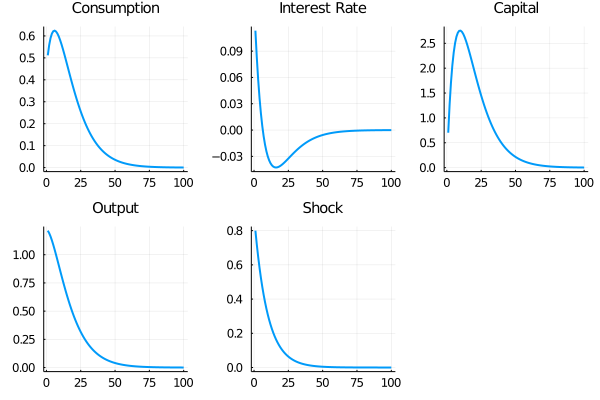

In [18]:
plot_C = plot(1:timeperiods, IRF[1, :], lw = 2, title = "Consumption")
plot_R = plot(1:timeperiods, IRF[2, :], lw = 2, title = "Interest Rate")
plot_K = plot(1:timeperiods, IRF[3, :], lw = 2, title = "Capital")
plot_Y = plot(1:timeperiods, IRF[4, :], lw = 2, title = "Output")
plot_Z = plot(1:timeperiods, IRF[5, :], lw = 2, title = "Shock")
plot(plot_C, plot_R, plot_K, plot_Y, plot_Z, legend = false, titlefont = font(10, "Arial"))